In [1]:
!nvidia-smi


Fri Dec 19 14:47:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import kagglehub


path = kagglehub.dataset_download("ahmedxc4/skin-ds")

print("Path to dataset files:", path)

100%|██████████| 9.25G/9.25G [01:43<00:00, 96.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedxc4/skin-ds/versions/2


In [3]:
import os

BASE_PATH = "/root/.cache/kagglehub/datasets/ahmedxc4/skin-ds/versions/2"

TRAIN_PATH = os.path.join(BASE_PATH, "train")
VAL_PATH   = os.path.join(BASE_PATH, "val")
TEST_PATH  = os.path.join(BASE_PATH, "test")

print(os.listdir(TRAIN_PATH))


['Basal cell carcinoma', 'Chickenpox', 'Benign keratosis-like lesions', 'Measles', 'Melanocytic nevi', 'Cowpox', 'Squamous cell carcinoma', 'Actinic keratoses', 'Healthy', 'Monkeypox', 'Dermatofibroma', 'Melanoma', 'HFMD', 'Vascular lesions']


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt


In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)


Found 29322 files belonging to 14 classes.
Found 3660 files belonging to 14 classes.
Found 3674 files belonging to 14 classes.
Classes: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Number of classes: 14


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [8]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [11]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)


In [12]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 14)        │      3,598 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,115,854 (91.99 MB)

 Trainable params: 528,142 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [14]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 223s 230ms/step - accuracy: 0.5826 - loss: 1.2779 - val_accuracy: 0.7153 - val_loss: 0.7846
Epoch 2/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 269s 243ms/step - accuracy: 0.6751 - loss: 0.8980 - val_accuracy: 0.7361 - val_loss: 0.7282
Epoch 3/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 246s 225ms/step - accuracy: 0.6981 - loss: 0.8343 - val_accuracy: 0.7445 - val_loss: 0.7064
Epoch 4/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 279s 244ms/step - accuracy: 0.7100 - loss: 0.7899 - val_accuracy: 0.7456 - val_loss: 0.7049
Epoch 5/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 264s 246ms/step - accuracy: 0.7221 - loss: 0.7730 - val_accuracy: 0.7533 - val_loss: 0.6722
Epoch 6/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 244s 227ms/step - accuracy: 0.7316 - loss: 0.7520 - val_accuracy: 0.7508 - val_loss: 0.6910
Epoch 7/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 207s 226ms/step - accuracy: 0.7286 - loss: 0.7419 - val_accuracy: 0.7601 - val_loss: 0.6693
Epoch 8/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 208s 226ms/step - accuracy: 0.7408 -

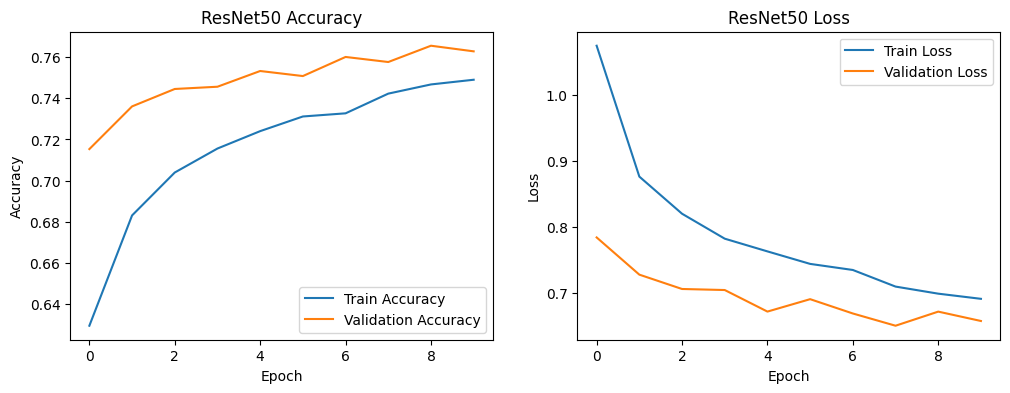

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Loss")
plt.legend()

plt.show()


In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


In [17]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False


In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [19]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)


Epoch 1/5
917/917 ━━━━━━━━━━━━━━━━━━━━ 242s 246ms/step - accuracy: 0.6489 - loss: 1.2740 - val_accuracy: 0.7746 - val_loss: 0.6379
Epoch 2/5
917/917 ━━━━━━━━━━━━━━━━━━━━ 253s 240ms/step - accuracy: 0.7524 - loss: 0.6890 - val_accuracy: 0.7863 - val_loss: 0.5930
Epoch 3/5
917/917 ━━━━━━━━━━━━━━━━━━━━ 262s 240ms/step - accuracy: 0.7795 - loss: 0.6173 - val_accuracy: 0.7956 - val_loss: 0.5708
Epoch 4/5
917/917 ━━━━━━━━━━━━━━━━━━━━ 221s 241ms/step - accuracy: 0.7836 - loss: 0.5788 - val_accuracy: 0.7956 - val_loss: 0.5647
Epoch 5/5
917/917 ━━━━━━━━━━━━━━━━━━━━ 264s 243ms/step - accuracy: 0.7986 - loss: 0.5469 - val_accuracy: 0.8016 - val_loss: 0.5495


In [20]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")


115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - accuracy: 0.7492 - loss: 0.7575
Final Test Accuracy: 80.05%


In [21]:
import os

def count_images(folder):
    total = 0
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            total += len(os.listdir(cls_path))
    return total

print("Training images:", count_images(TRAIN_PATH))
print("Validation images:", count_images(VAL_PATH))
print("Test images:", count_images(TEST_PATH))


Training images: 29322
Validation images: 3660
Test images: 3674


In [22]:
plt.savefig("resnet50_accuracy_loss.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>